# Data Collection, Training and Testing of ASL Model

In [4]:
## Importing necessary Libraries
import cv2 as cv 
import numpy as np 
import pandas as pd 
import tensorflow as tf 
import mediapipe as mp 
import random
import os
import matplotlib.pyplot as plt


### Data Collection

### Viewing random image from dataset

In [31]:
def view_random_image(target_dir,target_class):
    target_folder = target_dir+target_class

    random_image = random.sample(os.listdir(target_folder),1)
    img = cv.imread(target_folder+'/'+random_image[0])
    plt.imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB))
    
    return img

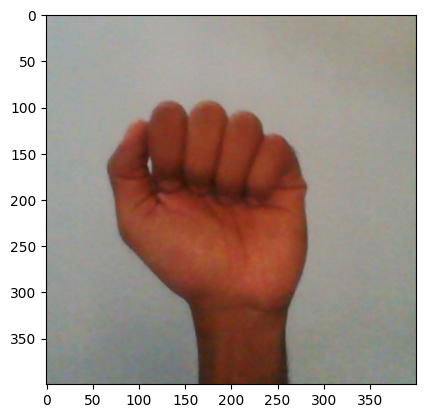

In [32]:
unlandmarked_image = view_random_image(target_dir='./ASL_Dataset/Train/',target_class='A')

### Creating a Mediapipe Model to fetch landmarks from image

In [33]:
from mediapipe.tasks import python 
from mediapipe.tasks.python import vision

#### Loading And Initializing Mediapipe Hand Detection Model

In [34]:
model_file = open('./Mediapipe_Model/hand_landmarker.task', "rb")
model_data = model_file.read()
model_file.close()

In [35]:
base_options = python.BaseOptions(model_asset_buffer=model_data)
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=1)
detector = vision.HandLandmarker.create_from_options(options)
mp_drawing = mp.solutions.drawing_utils ## to draw stuff


#### Creating A Hand Detection Function

In [36]:

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np


In [37]:
def mediapipe_detection(image,model):
    image = cv.cvtColor(image,cv.COLOR_BGR2RGB)
    image.flags.writeable = False
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image)
    results = model.detect(mp_image)
    image.flags.writeable = True
    image = cv.cvtColor(image,cv.COLOR_RGB2BGR)
    return image,results

In [76]:
#@markdown We implemented some functions to visualize the hand landmark detection results. <br/> Run the following cell to activate the functions.

MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image(rgb_image, detection_result):
  hand_landmarks_list = detection_result.hand_landmarks
  handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)
  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    # print("Landmark Data->")
    # print(hand_landmarks)
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS)


  return annotated_image

Landmark Data->
[NormalizedLandmark(x=0.5075056552886963, y=0.7825082540512085, z=-1.6951529460129677e-06, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.35915717482566833, y=0.7046059966087341, z=-0.07237932085990906, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.2393771857023239, y=0.5577306151390076, z=-0.10933467745780945, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.207645446062088, y=0.4172745943069458, z=-0.14451979100704193, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.2602090835571289, y=0.32417920231819153, z=-0.1583189219236374, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.3415714502334595, y=0.37579476833343506, z=-0.02182895503938198, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.33711573481559753, y=0.2670632004737854, z=-0.10613912343978882, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.33140677213668823, y=0.4086698591709137, z=-0.13896378874778748, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.3452922701

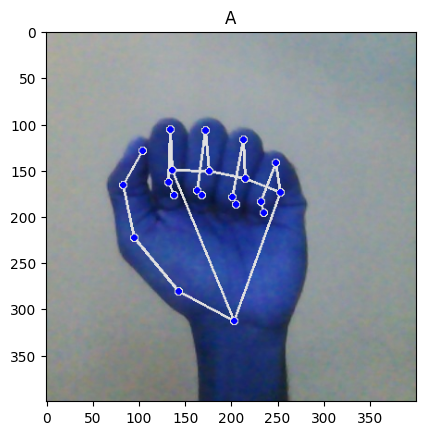

In [49]:
image,results = mediapipe_detection(unlandmarked_image,detector)
annotated_image = draw_landmarks_on_image(image,results)
plt.imshow(annotated_image)
plt.title('A')
plt.show()

## Collecting Landmark Data from the Image Dataset

In [50]:
folder_path_train= './archive/ASL_Dataset/Train/'
folder_path_test= './archive/ASL_Dataset/Test/'

In [51]:
## Function to Get images from dataset and extract hand landmark data
def get_images(path):
    label_list = np.array([])
    landmark_list = np.array([[[0,0,0] for i in range(21)]])
    for folder_path,_,files in os.walk(path):
        for file in files:
            try:
                file_path = os.path.join(folder_path,file)
                image = cv.imread(file_path)
                image,result = mediapipe_detection(image,detector)
                # print(res)
                if result.hand_landmarks:
                    result_list = np.array([[landmark.x,landmark.y,landmark.z] for landmark in result.hand_landmarks[0]])
                    # print(np.array(result_list))
                    landmark_list = np.concatenate((landmark_list,result_list.reshape(1,21,3)),axis=0)
                    # print(result_list)
                    label_list = np.concatenate((label_list,[folder_path.split('/')[-1]]),axis=0)
                    print(landmark_list.shape,label_list.shape)
                    
            except:
                continue
        # print(folder_path)
    return landmark_list,label_list
            



In [ ]:
## Will take 2 hours to Collect data instead use the landmark_data.npy and label_data.npy files to load Landmark Data and its Labels
## If you have more images in the dataset folder you can rerun from this cell
landmark_list,label_list = get_images(folder_path_train)

In [52]:
## Saving Landmark Data 
np.save('landmark_data.npy',landmark_list)

NameError: name 'landmark_list' is not defined

In [53]:
## Saving Corresponding Label Data
np.save('label_data.npy',label_list)

NameError: name 'label_list' is not defined

## Loading Landmark Data

In [58]:
## Landmark Data
landmark_data = np.load('./Landmark_Data/landmark_data.npy')
landmark_data,landmark_data.shape

(array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],
 
        [[ 3.80075872e-01,  8.25044394e-01, -8.25388497e-07],
         [ 2.75580198e-01,  7.87166834e-01, -4.02420722e-02],
         [ 1.91976130e-01,  6.85196877e-01, -5.35917915e-02],
         ...,
         [ 4.28225130e-01,  5.32508075e-01, -4.24192660e-02],
         [ 4.14040744e-01,  5.98226786e-01, -2.33819708e-02],
         [ 4.17300284e-01,  6.28699958e-01,  8.86152033e-04]],
 
        [[ 4.00400162e-01,  8.85031343e-01, -9.17442321e-07],
         [ 2.99903303e-01,  8.37341428e-01, -4.04743925e-02],
         [ 2.21760392e-01,  7.40960836e-01, -5.88775836e-02],
         ...,
         [ 4.63501245e

In [59]:
## Label Data
label_data = np.load('./Landmark_Data/label_data.npy')
label_data,label_data.shape 

(array(['A', 'A', 'A', ..., 'Z', 'Z', 'Z'], dtype='<U32'), (65354,))

In [61]:
## Encoding Label Data(Categorical Data)
from sklearn.preprocessing import LabelBinarizer
label_one_hot = LabelBinarizer().fit_transform(label_data) 

### Creating Train Test Split

In [60]:
from sklearn.model_selection import train_test_split

In [62]:
X_train,X_test,y_train,y_test = train_test_split(landmark_data[1:],label_one_hot.astype(int),test_size=0.2)

NOTE: ` Please Ignore the first Landmark Record Since its All Zeroes `
hence the ` landmark_data[1:] ` 

In [63]:
print('X_train Shape:',X_train.shape)
print('y_train Shape:',y_train.shape)
print('X_test Shape:',X_test.shape)
print('y_test Shape:',y_test.shape)

X_train Shape: (52283, 21, 3)
y_train Shape: (52283, 27)
X_test Shape: (13071, 21, 3)
y_test Shape: (13071, 27)


> * X - Contains x,y,z coordinates of 21 hand landmarks that the mediapipe model detects [i.e One set of (21,3)] ,
<br> 
hence each set of (21,3) is the data of one hand sign
<br>

> * y - Binary(1/0) Labels for each alphabet [26 English Alphabets + 'Space' sign] 

### Creating Baseline Model

In [66]:
model_bs = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (21,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,activation='relu' ),
    tf.keras.layers.Dense(32,activation='relu' ),
    tf.keras.layers.Dense(27,activation ='sigmoid'),
]) 
model_bs.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),metrics = ['Accuracy'])

In [67]:
model_bs.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 63)                0         
                                                                 
 dense_3 (Dense)             (None, 64)                4096      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 27)                891       
                                                                 
Total params: 7,067
Trainable params: 7,067
Non-trainable params: 0
_________________________________________________________________


### Fitting The Data and Training the Model

In [68]:
model_bs =  model_bs.fit(X_train.astype(float),y_train.astype(float),epochs=3,steps_per_epoch=(X_train.shape[0]),validation_data=(X_test.astype(float),y_test.astype(float)))

Epoch 1/3
52283/52283 [==============================] - 97s 2ms/step - loss: 1.0969 - Accuracy: 0.5856 - val_loss: 0.4007 - val_Accuracy: 0.8658
Epoch 2/3
52283/52283 [==============================] - 94s 2ms/step - loss: 0.5413 - Accuracy: 0.8200 - val_loss: 0.8390 - val_Accuracy: 0.6778
Epoch 3/3
52283/52283 [==============================] - 98s 2ms/step - loss: 0.5076 - Accuracy: 0.8379 - val_loss: 0.4064 - val_Accuracy: 0.8735


### New model with following changes
> * Added a new layer
<br>

> * Decreased learning rate to 0.005

In [69]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (21,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation='relu' ),
    tf.keras.layers.Dense(64,activation='relu' ),
    tf.keras.layers.Dense(32,activation='relu' ),
    tf.keras.layers.Dense(27,activation ='sigmoid'),
]) 
model_1.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(learning_rate=0.005),metrics = ['Accuracy'])

In [70]:
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 63)                0         
                                                                 
 dense_6 (Dense)             (None, 128)               8192      
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 27)                891       
                                                                 
Total params: 19,419
Trainable params: 19,419
Non-trainable params: 0
_________________________________________________________________


In [71]:
model_1_hs =  model_1.fit(X_train.astype(float),y_train.astype(float),epochs=3,steps_per_epoch=(X_train.shape[0]),validation_data=(X_test.astype(float),y_test.astype(float)))

Epoch 1/3
52283/52283 [==============================] - 104s 2ms/step - loss: 0.4944 - Accuracy: 0.8319 - val_loss: 0.0895 - val_Accuracy: 0.9668
Epoch 2/3
52283/52283 [==============================] - 103s 2ms/step - loss: 0.2174 - Accuracy: 0.9447 - val_loss: 0.0435 - val_Accuracy: 0.9893
Epoch 3/3
52283/52283 [==============================] - 96s 2ms/step - loss: 0.2238 - Accuracy: 0.9517 - val_loss: 0.0306 - val_Accuracy: 0.9928


<b>When I tried to perform real time testing [` Test to see if the model can detect real world hand signs `] </b>
<br>
I Faced the Following issue :
***
* The Model was getting confused between few sets of Alphabets
<br>
* To solve this issue I started grouping alphabets which get confused the most with each other


### Identifying Groups

In [74]:
## Function to Display groups of confused alphabets
def print_confused_alpha(list):
    fig,axes = plt.subplots(1,len(list),figsize=(6,6))
    axes = axes.flatten()
    for i in range(len(list)):
        image = view_random_image(target_dir='./ASL_Dataset/Train/',target_class=list[i])
        image,results = mediapipe_detection(image,detector)
        annotated_image = draw_landmarks_on_image(image,results)
        # print('h',[(landmark) for landmark in results.hand_landmarks[0]])
        axes[i].imshow(cv.cvtColor(annotated_image,cv.COLOR_BGR2RGB),label=list[i])
        axes[i].set_title(list[i])
        axes[i].axis('off')
        
    plt.legend()
    plt.tight_layout()
    plt.show()

#### <b>Group1 : [ L , S , X ]</b>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


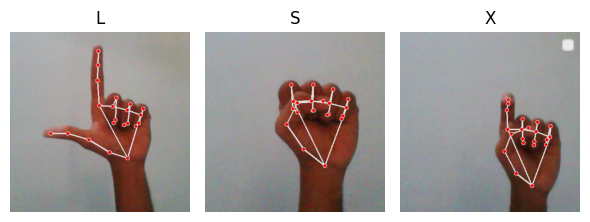

In [77]:
print_confused_alpha(['L','S','X'])

#### <b>Group2 : [ A , E , T ]</b>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


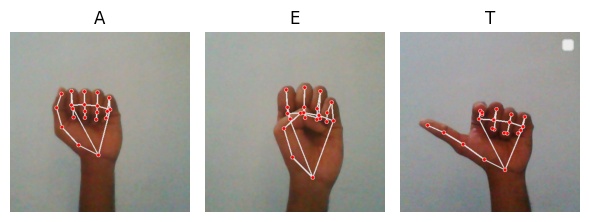

In [78]:
print_confused_alpha(['A','E','T'])

#### <b>Group3 : [ H , K , W ]</b>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


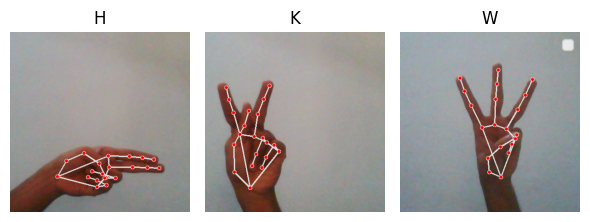

In [79]:
print_confused_alpha(['H','K','W'])

#### <b>Group4 : [ R , U , W ]</b>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


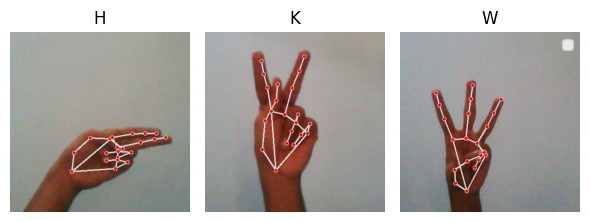

In [80]:
print_confused_alpha(['H','K','W'])

#### <b>Group5 : [ C , D , O ]</b>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


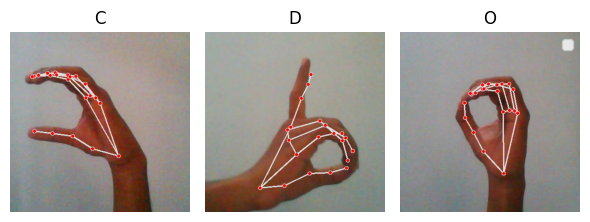

In [81]:
print_confused_alpha(['C','D','O'])

#### <b>Group6 : [ G , H , P ]</b>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


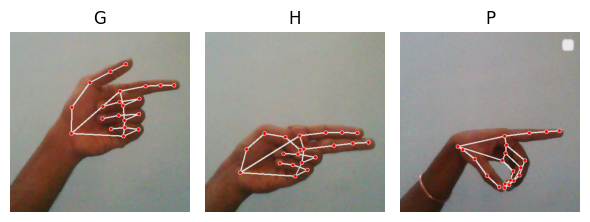

In [82]:
print_confused_alpha(['G','H','P'])

## Creating Seperate Model for each group

In [85]:
## Creating function to get train and test data given a group of alphabets

def get_train_test_split(list):
    mask = np.isin(label_data,list)
    X = landmark_data[1:][mask]
    y = label_data[mask]
    one_hot_encoder = LabelBinarizer()
    y = one_hot_encoder.fit_transform(y)
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

    return X_train,X_test,y_train,y_test

#### Model for Group 1 [ L , S , X]

In [90]:
## train test split for group 1
g1_X_train,g1_X_test,g1_y_train,g1_y_test = get_train_test_split(['L','S','X'])

In [91]:
print('g1_X_train Shape:',g1_X_train.shape)
print('g1_y_train Shape:',g1_y_train.shape)
print('g1_X_test Shape:',g1_X_test.shape)
print('g1_y_test Shape:',g1_y_test.shape)

g1_X_train Shape: (6291, 21, 3)
g1_y_train Shape: (6291, 3)
g1_X_test Shape: (1573, 21, 3)
g1_y_test Shape: (1573, 3)


In [92]:
## model for group1
model_g1 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (21,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation='relu' ),
    tf.keras.layers.Dense(64,activation='relu' ),
    tf.keras.layers.Dense(32,activation='relu' ),
    tf.keras.layers.Dense(3,activation ='sigmoid'),
]) 
model_g1.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(learning_rate=0.005),metrics = ['Accuracy'])

In [93]:
model_g1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 63)                0         
                                                                 
 dense_10 (Dense)            (None, 128)               8192      
                                                                 
 dense_11 (Dense)            (None, 64)                8256      
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 3)                 99        
                                                                 
Total params: 18,627
Trainable params: 18,627
Non-trainable params: 0
_________________________________________________________________


In [94]:
model_g1_hs = model_g1.fit(g1_X_train.astype(float),g1_y_train.astype(float),epochs=3,steps_per_epoch=(g1_X_train.shape[0]),validation_data=(g1_X_test.astype(float),g1_y_test.astype(float)))

Epoch 1/3
6291/6291 [==============================] - 9s 1ms/step - loss: 0.1070 - Accuracy: 0.9598 - val_loss: 2.7145e-04 - val_Accuracy: 1.0000
Epoch 2/3
6291/6291 [==============================] - 8s 1ms/step - loss: 0.0125 - Accuracy: 0.9981 - val_loss: 1.7078e-05 - val_Accuracy: 1.0000
Epoch 3/3
6291/6291 [==============================] - 7s 1ms/step - loss: 3.8164e-06 - Accuracy: 1.0000 - val_loss: 4.9828e-07 - val_Accuracy: 1.0000


In [ ]:
tf.saved_model.save(model_g1,'./ASL_Models/ASL_g1_model')

In [97]:
## This function basically just does what the above few cells just did [So that we can easily create models for other groups of alphabets] And iam lazy heheehhe
def get_group_model(list):
    X_train,X_test,y_train,y_test = get_train_test_split(list)
    ## Printing Shape of Data
    print('DATA')
    print('g1_X_train Shape:',g1_X_train.shape)
    print('g1_y_train Shape:',g1_y_train.shape)
    print('g1_X_test Shape:',g1_X_test.shape)
    print('g1_y_test Shape:',g1_y_test.shape)
    print('---------------------------------')
    model =  tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (21,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation='relu' ),
    tf.keras.layers.Dense(64,activation='relu' ),
    tf.keras.layers.Dense(32,activation='relu' ),
    tf.keras.layers.Dense(len(list) if len(list)!=2 else 1,activation ='sigmoid'),
    ]) 

    ## Model Summary
    model.summary()

    ## Model Compile
    model.compile(loss = tf.keras.losses.CategoricalCrossentropy() if len(list)!=2 else tf.keras.losses.BinaryCrossentropy(),optimizer = tf.keras.optimizers.Adam(learning_rate=0.005),metrics = ['Accuracy'])

    ## Fitting And training Model
    model_hs = model.fit(X_train.astype(float),y_train.astype(float),epochs=3,steps_per_epoch=(X_train.shape[0]),validation_data=(X_test.astype(float),y_test.astype(float)))
    return model,model_hs

#### Model for Group 2 [ A , E , T]

In [98]:
model_g2,model_g2_hs = get_group_model(['A','E','T']) 

DATA
g1_X_train Shape: (6291, 21, 3)
g1_y_train Shape: (6291, 3)
g1_X_test Shape: (1573, 21, 3)
g1_y_test Shape: (1573, 3)
---------------------------------
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 63)                0         
                                                                 
 dense_18 (Dense)            (None, 128)               8192      
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 dense_20 (Dense)            (None, 32)                2080      
                                                                 
 dense_21 (Dense)            (None, 3)                 99        
                                                                 
Total params: 18,627
Trainabl

In [ ]:
tf.saved_model.save(model_g2,'./ASL_Models/ASL_g2_model')

#### Model for Group 3 [ H , K , W]

In [99]:
model_g3,model_g3_hs = get_group_model(['H','K','W'])

DATA
g1_X_train Shape: (6291, 21, 3)
g1_y_train Shape: (6291, 3)
g1_X_test Shape: (1573, 21, 3)
g1_y_test Shape: (1573, 3)
---------------------------------
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 63)                0         
                                                                 
 dense_22 (Dense)            (None, 128)               8192      
                                                                 
 dense_23 (Dense)            (None, 64)                8256      
                                                                 
 dense_24 (Dense)            (None, 32)                2080      
                                                                 
 dense_25 (Dense)            (None, 3)                 99        
                                                                 
Total params: 18,627
Trainabl

In [ ]:
tf.saved_model.save(model_g3,'./ASL_Models/ASL_g3_model')

#### Model for Group 4 [ R , U , V]

In [100]:
model_g4,model_g4_hs = get_group_model(['R','U','V'])

DATA
g1_X_train Shape: (6291, 21, 3)
g1_y_train Shape: (6291, 3)
g1_X_test Shape: (1573, 21, 3)
g1_y_test Shape: (1573, 3)
---------------------------------
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 63)                0         
                                                                 
 dense_26 (Dense)            (None, 128)               8192      
                                                                 
 dense_27 (Dense)            (None, 64)                8256      
                                                                 
 dense_28 (Dense)            (None, 32)                2080      
                                                                 
 dense_29 (Dense)            (None, 3)                 99        
                                                                 
Total params: 18,627
Trainabl

#### Model for Group 5 [ C , D , O ]

In [101]:
model_g5,model_g5_hs = get_group_model(['C','D','O'])

DATA
g1_X_train Shape: (6291, 21, 3)
g1_y_train Shape: (6291, 3)
g1_X_test Shape: (1573, 21, 3)
g1_y_test Shape: (1573, 3)
---------------------------------
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 63)                0         
                                                                 
 dense_30 (Dense)            (None, 128)               8192      
                                                                 
 dense_31 (Dense)            (None, 64)                8256      
                                                                 
 dense_32 (Dense)            (None, 32)                2080      
                                                                 
 dense_33 (Dense)            (None, 3)                 99        
                                                                 
Total params: 18,627
Trainabl

Epoch 1/3
5874/5874 [==============================] - 9s 1ms/step - loss: 0.1422 - Accuracy: 0.9496 - val_loss: 0.0155 - val_Accuracy: 0.9939
Epoch 2/3
5874/5874 [==============================] - 7s 1ms/step - loss: 0.0520 - Accuracy: 0.9898 - val_loss: 0.0082 - val_Accuracy: 0.9973
Epoch 3/3
5874/5874 [==============================] - 7s 1ms/step - loss: 0.0534 - Accuracy: 0.9884 - val_loss: 0.0030 - val_Accuracy: 0.9980


In [ ]:
tf.saved_model.save(model_g5,'./ASL_Models/ASL_g5_model')

#### Model for Group 6 [ G , H , P]

In [102]:
model_g6,model_g6_hs = get_group_model(['G','H','P'])

DATA
g1_X_train Shape: (6291, 21, 3)
g1_y_train Shape: (6291, 3)
g1_X_test Shape: (1573, 21, 3)
g1_y_test Shape: (1573, 3)
---------------------------------
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 63)                0         
                                                                 
 dense_34 (Dense)            (None, 128)               8192      
                                                                 
 dense_35 (Dense)            (None, 64)                8256      
                                                                 
 dense_36 (Dense)            (None, 32)                2080      
                                                                 
 dense_37 (Dense)            (None, 3)                 99        
                                                                 
Total params: 18,627
Trainabl

Epoch 1/3
5726/5726 [==============================] - 9s 1ms/step - loss: 0.1112 - Accuracy: 0.9586 - val_loss: 3.6563e-04 - val_Accuracy: 1.0000
Epoch 2/3
5726/5726 [==============================] - 8s 1ms/step - loss: 0.2178 - Accuracy: 0.8915 - val_loss: 0.3127 - val_Accuracy: 0.9846
Epoch 3/3
5726/5726 [==============================] - 7s 1ms/step - loss: 0.0368 - Accuracy: 0.9907 - val_loss: 7.2353e-04 - val_Accuracy: 1.0000


In [ ]:
tf.saved_model.save(model_g6,'./ASL_Models/ASL_g6_model')

Now when I performed Real Time Testing by Performing Predictions on Two Levels
* One Vague Prediction over All Alphabets
* Second Strong Prediction with Smaller Group

The Overall 2 Level Model Performed better than the older 1 Level Model
<br>
***
<b>But Still the Model Gets confused with the following Alphabet Groups:</b>

* G , H
* M , N 
* U , V , K
